#Figure 8 supplement 1 - Functional imaging

This notebook loads in the data corresponding to figure 8 supplement 1

We then computes the mean intenstity image 8_1A), the local correlation image 8_1B)

## Setup plotting

In [18]:
from showit import image
%matplotlib inline

In [10]:
from skimage.io import imsave

##Loading in the data

In [2]:
path = '/tier2/freeman/Nick/2pRAM.paper/02'

In [3]:
from thunder.images import frombinary

data = frombinary(path + '/images', engine=sc)

##Detrend timeseries

In [4]:
from numpy import arange, polyfit, polyval

def detrend(y, order=5):
    x = arange(len(y))
    p = polyfit(x, y, order)
    p[-1] = 0
    yy = polyval(p, x)
    return y - yy

In [5]:
detrended = data.map_as_series(detrend, block_size = '10')
detrended.cache()

Images
mode: spark
dtype: float64
shape: (4044, 1682, 1792)

## Compute and inspect the mean image

In [6]:
mean = detrended.mean().toarray()

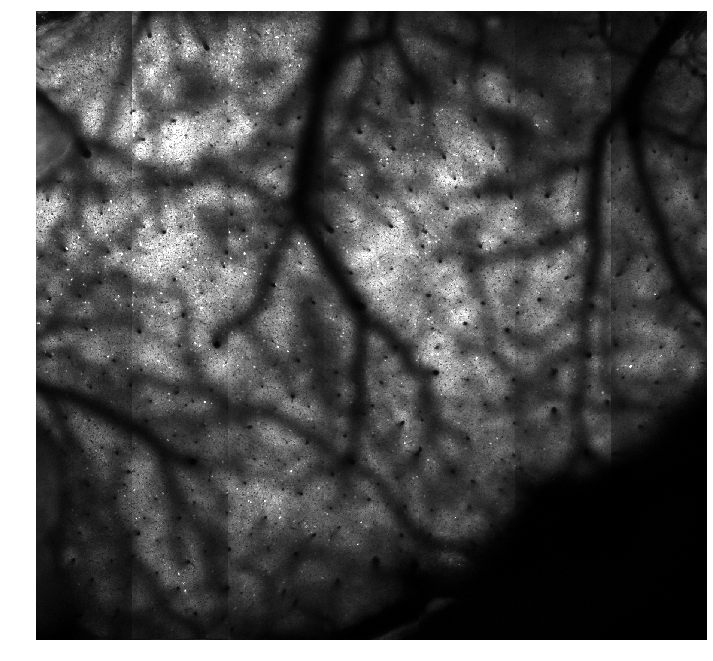

In [7]:
image(mean, clim=(0, 1000), size = 12);

In [13]:
imsave(path + '/summary/mean.tif', mean.astype('float32'), plugin='tifffile', photometric='minisblack')

## Compute and inspect local correlation image

In [8]:
localcorr = detrended.localcorr(4)

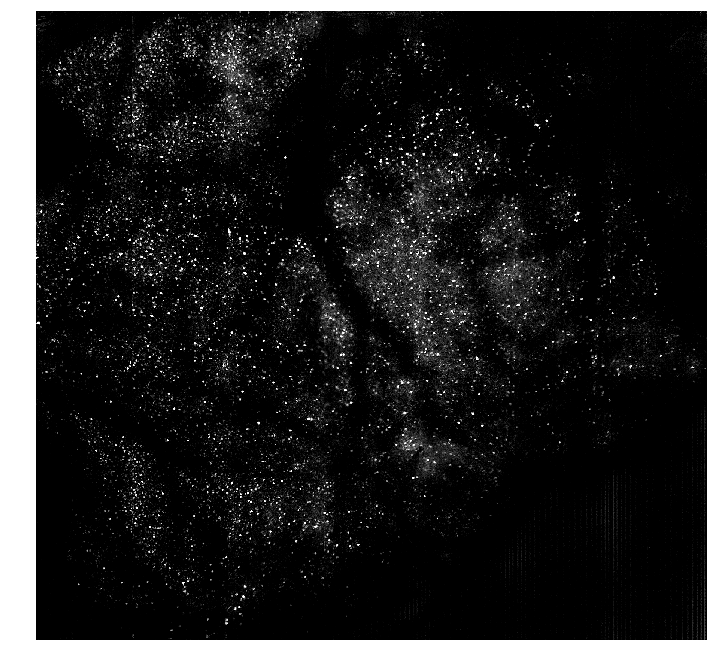

In [16]:
image(localcorr, clim=(0.3, 0.7), size = 12);

In [17]:
imsave(path + '/summary/localcorr.tif', localcorr.astype('float32'), plugin='tifffile', photometric='minisblack')